# Water Pump Predictive Maintenance 💧 
#### *using unsupervised learning techniques*

### Overview

The problem: In today's society we are bombarded with much data but often do not know how to use that information. This dataset was put on Kaggle so that smart minds could find patterns in the sensor data given by a local water pump. The proposal for this project is to use machine learning to detect patterns in the sensor data so that the pump owners will be better able to understand when a failure is about to occur. 

We begin this project by exploring the data provided. This project will use two unsupervised learning techniques including PCA (for feature extraction and dimensionalty reduction) and KMeans clusters. Then, supervised ML models are used to compare to the unsupervised Kmeans model. Finally, an overview and summary is provided at the end of the notebook. 

Note: each code cell has a brief explaination of what that cell does. Some code cells are hidden for easier readability in Kaggle notebooks but you can easily expand them to see the full code. 

### 1. 🧐 Exploratory Data Analysis 

Exploratory data analysis (EDA) is very important when it comes to working with data. In this project we look at all the data first instead of splitting into traing-test sets. Because this notebook is completed for a school project, we will be doing some data anaylsis not normally recommended. For example, looking at all the data before splitting it. The EDA section uses visualizations and performs very preliminary data preprocessing steps, such as deleting empty columns.

### 2. 🤓 Preprocessing

In the preprocessing step, we need to get the most useful parts of the data to feed to the machine learning model. First we will deal with missing data using forward propogation. Then we will use a common unsupervised learning technqiue call Principle Component Analysis (PCA) to reduce the number of sensors used in the next steps. PCA is a great tool for feature reduction.

### 3. 🦾 Modeling

Next, using KMeans clustering (an unsupervised ML model) we will try to determine where the failures are. Because Kmeans is unsupervised, we will use the best model recommendation for number of clusters. To compare our models later, we need to use some sort of performance testing such as accuracy, recall and/or precision. Since, in reality, we do know the labels of the data we can find the best labeling throught permutation. The cavet to this technique is if there are more clusters than given labels, our model may perform poorly according to accuracy, recall or precision. We will discuss this later in the notebook more. 

### 4. 🤜🤛 Model Comparison

After creating a KMeans cluster model, we will build a supervised learning model which also uses clustering such as K-Nearest Neighbors (KNN). We chose to use two clustering models for practice however, other possible models will be discussed in the following section.

### 5. 👏 Conclusions and Future Suggestions

This section includes a brief overview of the project and what was accomplished throughout. We review the different models used and how they performed. For a well-rounded project, we will reflect upon what could have been done differently to have a better model performance as well as things we could have changed in general and what their impact may have been. 

In [1]:
# import necessary libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing and modeling
import itertools
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# global parameters 
RANDOMSTATE = 101

# display file names
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/pump-sensor-data/sensor.csv


In [2]:
# load data 
dir_path = '/kaggle/input/pump-sensor-data/'
sensor_data = pd.read_csv(dir_path + 'sensor.csv')

------
# 1. Exploratory Data Analysis (EDA) 🧐

In EDA it is important to get a good understanding of the data you have to work with. In normal instances, we would not want to look at the testing and training datasets, however, for this specific project we will. We do this for a few reasons. First, this is a school project aimed to practice machine learning techniques. Since this data is time data and we will be using clustering models, we decided split after a quick peek. To add, we will see we have 3 labels for this data and we want to ensure that all labels are represented in the testing set. For this reason, we will decided where to split the data based on this. Also note, that this timeseries data has a lot of values associated and we are not as worried about loosing performance due to this. We will discuss further as we continue in the notebook.

In [3]:
# take a quick look at dataframe 
sensor_data.head()

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [4]:
# see the labels we have 
sensor_data['machine_status'].unique()

array(['NORMAL', 'BROKEN', 'RECOVERING'], dtype=object)

Great we see a general overview of the sensor data as well as the labels we will be working with. Next, we can take a look at the statistics presented in the raw data. This is one way to get a sense of the distribution of data as well as look for missing values. 

In [5]:
# get more info from the dataset 
sensor_data.describe()

,Unnamed: 0,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
count,220320.000000,210112.000000,219951.000000,220301.000000,220301.000000,220301.000000,220301.000000,215522.000000,214869.000000,215213.000000,...,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,143303.000000,204937.000000
mean,110159.500000,2.372221,47.591611,50.867392,43.752481,590.673936,73.396414,13.501537,15.843152,15.200721,...,35.453455,43.879591,42.656877,43.094984,48.018585,44.340903,150.889044,57.119968,183.049260,202.699667
std,63601.049991,0.412227,3.296666,3.666820,2.418887,144.023912,17.298247,2.163736,2.201155,2.037390,...,10.259521,11.044404,11.576355,12.837520,15.641284,10.442437,82.244957,19.143598,65.258650,109.588607
min,0.000000,0.000000,0.000000,33.159720,31.640620,2.798032,0.000000,0.014468,0.000000,0.028935,...,22.135416,24.479166,25.752316,26.331018,26.331018,27.199070,26.331018,26.620370,27.488426,27.777779
25%,55079.750000,2.438831,46.310760,50.390620,42.838539,626.620400,69.976260,13.346350,15.907120,15.183740,...,32.812500,39.583330,36.747684,36.747684,40.509258,39.062500,83.912030,47.743060,167.534700,179.108800
50%,110159.500000,2.456539,48.133678,51.649300,44.227428,632.638916,75.576790,13.642940,16.167530,15.494790,...,35.156250,42.968750,40.509260,40.219910,44.849540,42.534720,138.020800,52.662040,193.865700,197.338000
75%,165239.250000,2.499826,49.479160,52.777770,45.312500,637.615723,80.912150,14.539930,16.427950,15.697340,...,36.979164,46.614580,45.138890,44.849540,51.215280,46.585650,208.333300,60.763890,219.907400,216.724500
max,220319.000000,2.549016,56.727430,56.032990,48.220490,800.000000,99.999880,22.251160,23.596640,24.348960,...,374.218800,408.593700,1000.000000,320.312500,370.370400,303.530100,561.632000,464.409700,1000.000000,1000.000000


In [6]:
# get further info from dataset
sensor_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 55 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      220320 non-null  int64  
 1   timestamp       220320 non-null  object 
 2   sensor_00       210112 non-null  float64
 3   sensor_01       219951 non-null  float64
 4   sensor_02       220301 non-null  float64
 5   sensor_03       220301 non-null  float64
 6   sensor_04       220301 non-null  float64
 7   sensor_05       220301 non-null  float64
 8   sensor_06       215522 non-null  float64
 9   sensor_07       214869 non-null  float64
 10  sensor_08       215213 non-null  float64
 11  sensor_09       215725 non-null  float64
 12  sensor_10       220301 non-null  float64
 13  sensor_11       220301 non-null  float64
 14  sensor_12       220301 non-null  float64
 15  sensor_13       220301 non-null  float64
 16  sensor_14       220299 non-null  float64
 17  sensor_15 

From this information, we see we have a handful of missing values. We will delete the following columns. 

In [7]:
# we see that one column (sensor_15) has no values therefore we will delete that column 
sensor_data = sensor_data.drop('sensor_15', axis = 1)

In [8]:
# sensor 50 also is missing 34.95% of its data so we will delete that column as well. 
sensor_data = sensor_data.drop('sensor_50', axis =1) 

In [9]:
# We will delete sensor_00 and sensor_51 which are both missing close to 6-7% of their data. 
# as well as the Unnamed:0 column which is essentially the index column duplicate
sensor_data = sensor_data.drop('Unnamed: 0', axis =1)
sensor_data = sensor_data.drop('sensor_00', axis =1) 
sensor_data = sensor_data.drop('sensor_51', axis =1) 


Next, we see a missing data heatmap after we removed the prior columns. We see we still have missing values.

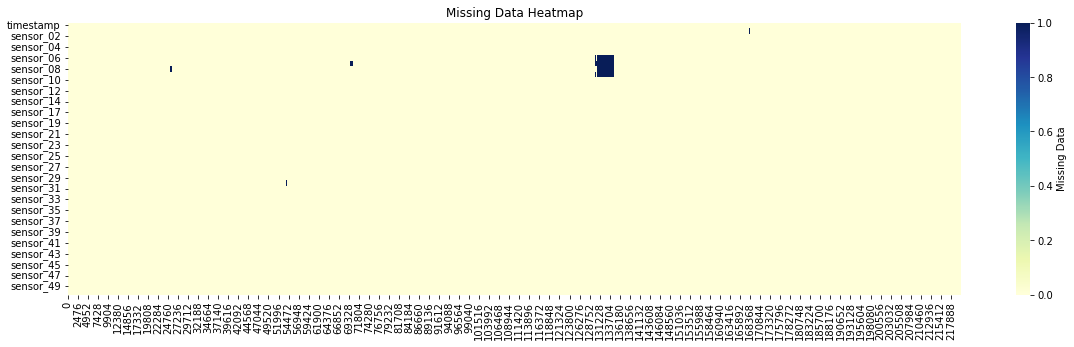

In [10]:
# this cell is hidden for easier notebook readability.
# plot a heatmap of the missing values
plt.figure(figsize=(20,5))
sns.heatmap(sensor_data.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})
plt.title('Missing Data Heatmap')
plt.show();

We see a large chunk where multiple sensors failed to record at the same time. This could have been caused by weather, electrical malfunction, maintanence, or many other factors. Since this could be an indicator of the system being down, we will leave these in and deal will missing values later on. We have two options, either we delete the rest of the rows which are missing values. Each column is missing about 2% or less of its data or, we can fill in the missing values. However, before we do anything to the data, we will **split** it into **training and testing data using a 60/40 split.** And, since this is timeseries data and we want to predict on theoretically new data, we will take the last 40% from the dataset as the testing data (new data). We could split the data randomly into training and testing but since we really want to try to predict failure in future, we will study the first 60% (current history) and try to predict the last 40% (future). Normally we wouldn't recommend such large percentages of values to be used in the testing data (usually use around 20%) but in this instance, we have (we think) sufficient rows to train a model. But, more importantly, we have 7 failures (BROKEN instance). We will put at least 2 in the testing set to see if the model can detect them.

In [11]:
#split data 60/40 with last 40% as the test set
last_40percent = round(len(sensor_data) - len(sensor_data)*.4)
train = sensor_data.iloc[ :last_40percent, :]
test = sensor_data.iloc[last_40percent: ,:]

In [12]:
test[test['machine_status']=='BROKEN']

,timestamp,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,machine_status
141131,2018-07-08 00:11:00,45.138890,52.90799,45.35590,500.000000,1.40131,0.028935,0.036169,0.036169,0.007234,...,35.41666,32.81250,36.19791,37.32639,35.30093,38.19444,43.40278,99.53703,44.84954,BROKEN
166440,2018-07-25 14:00:00,45.833332,52.99479,43.88021,420.503448,72.52040,14.185470,16.247110,15.697340,15.053530,...,35.41666,36.45833,51.30208,52.10200,52.66204,67.12963,43.98148,230.32410,69.73380,BROKEN


## ⭐️ Visualization ⭐️

Now that we have our training set ready to go, let's visualize the training data and explore the it further to get some insights!

In [13]:
# get useful columns and rows
sensor_cols = train.iloc[:,1:49]
broken_rows = train[train['machine_status']=='BROKEN']
recovery_rows = train[train['machine_status']=='RECOVERING']
normal_rows = train[train['machine_status']=='NORMAL']
machine_status_col = train['machine_status']

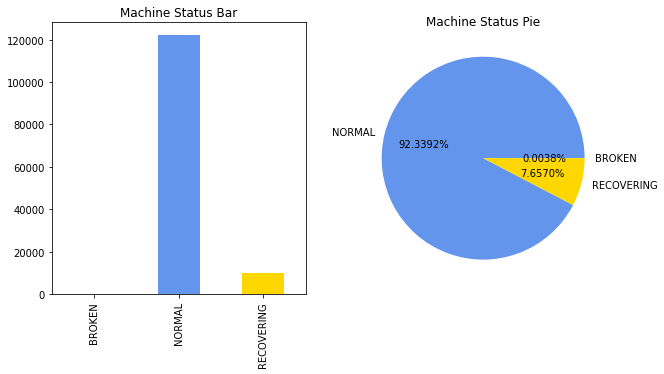

In [14]:
# this cell is hidden for easier notebook readability.

# pie chart of machine status
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))
train.groupby('machine_status').size().plot(kind='bar', ax=ax1, color=['black', 'cornflowerblue', 'gold'])
train.groupby('machine_status').size().plot(kind='pie', ax=ax2, autopct='%.4f%%', colors=['black', 'cornflowerblue', 'gold'])
ax1.set_title('Machine Status Bar')
ax1.set_xlabel('')
ax2.set_title('Machine Status Pie')
ax2.set_ylabel('')
plt.show();

As we can see, majority of the time the sensors register NORMAL. This makes sense because the pump should be working normally most of the time. We then see the RECOVERING as the next group, which also makes sense given that the machine breaks then take a bit to recover. Lastly, only 0.004% of the data is in BROKEN status. This is okay because a machine breaks, and in theory, shouldn't be broken for very long. 

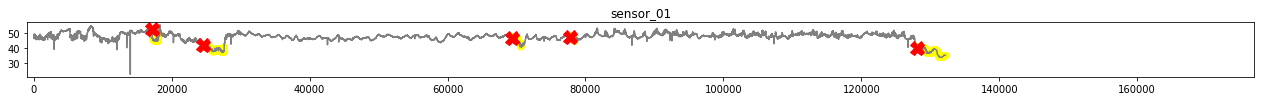

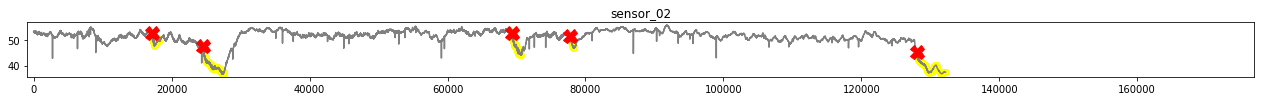

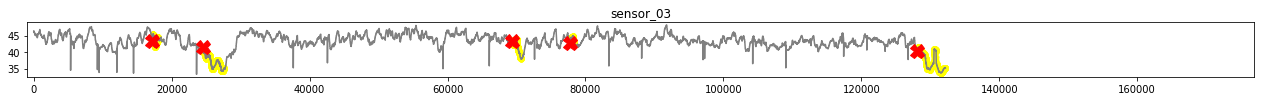

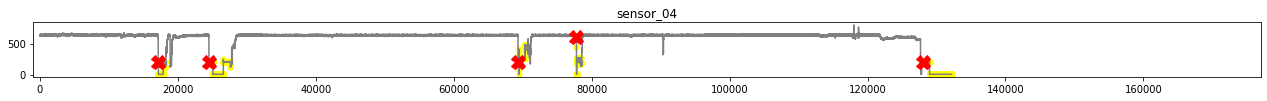

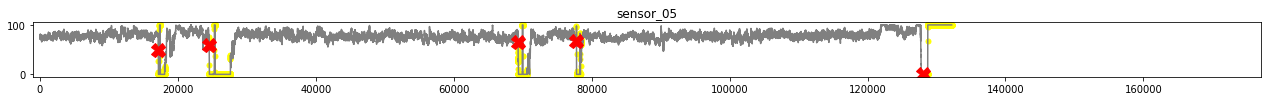

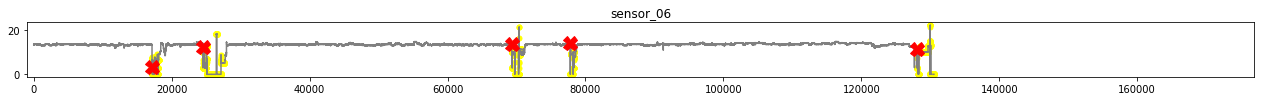

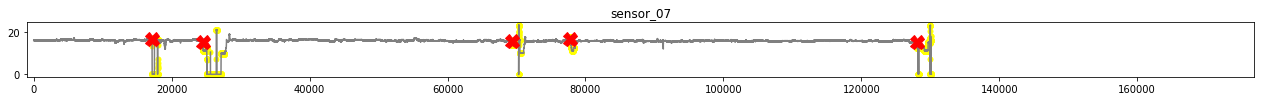

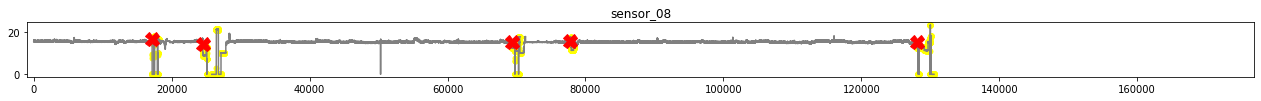

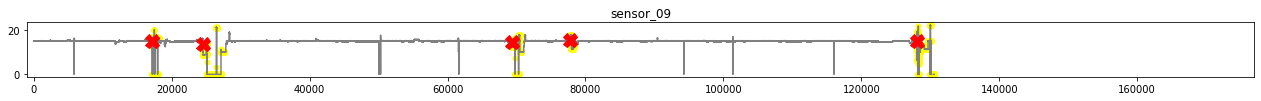

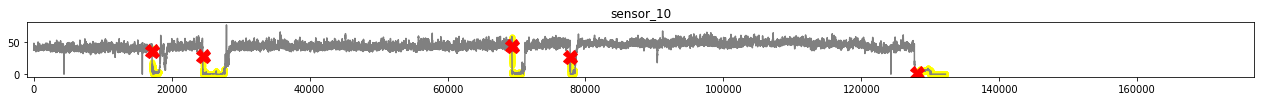

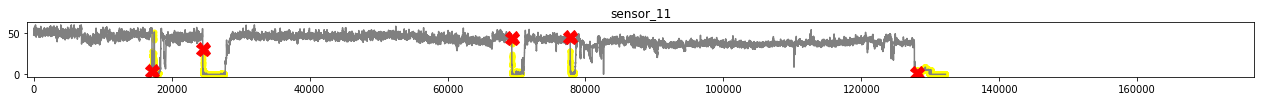

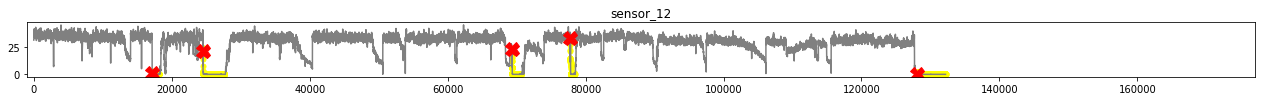

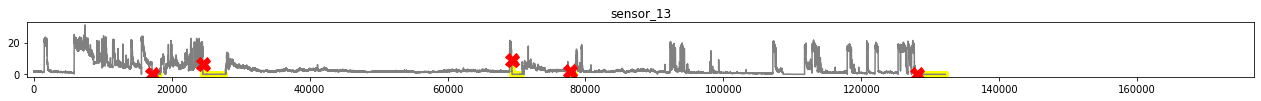

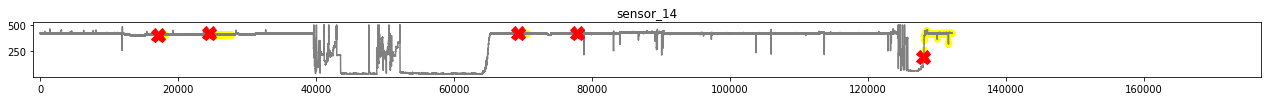

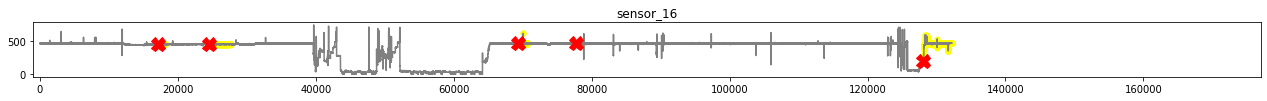

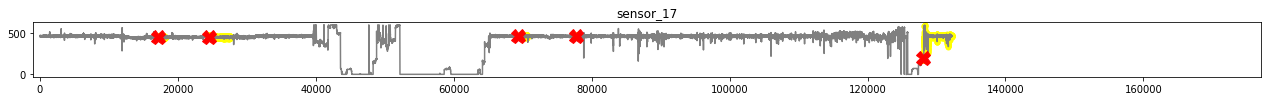

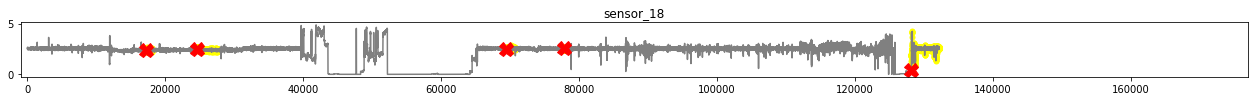

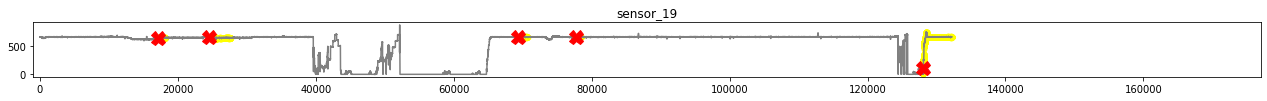

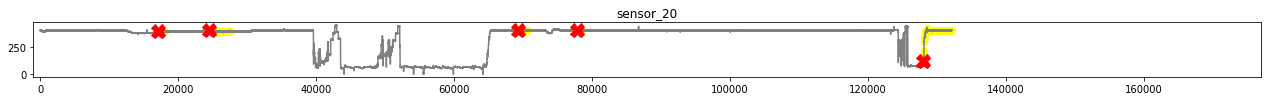

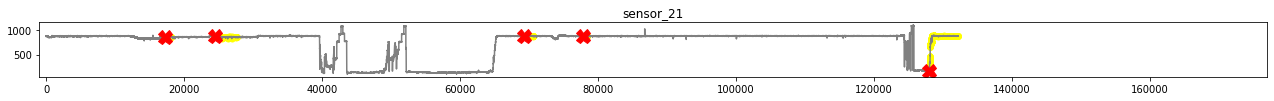

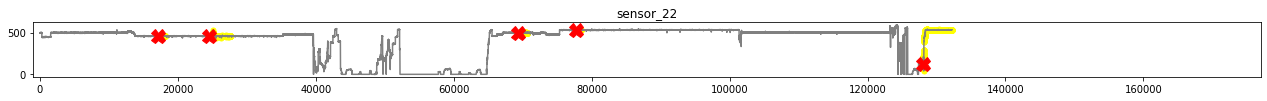

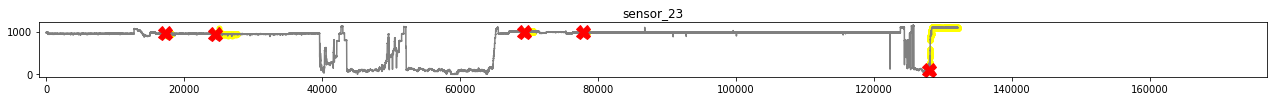

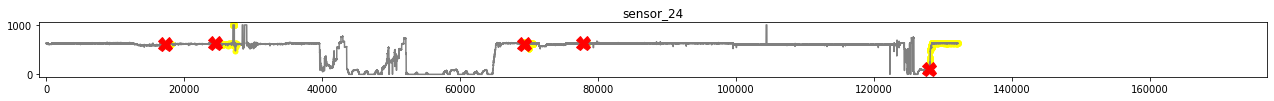

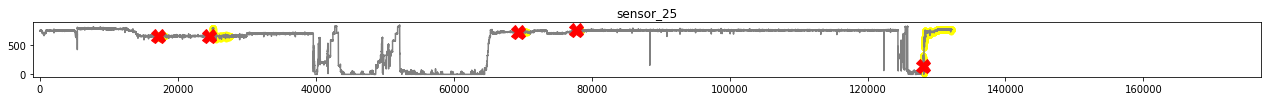

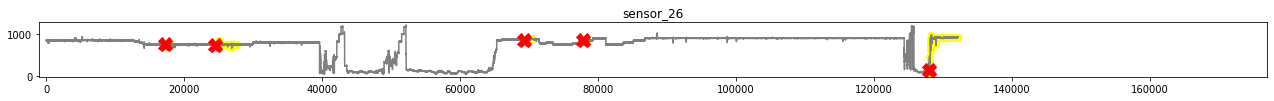

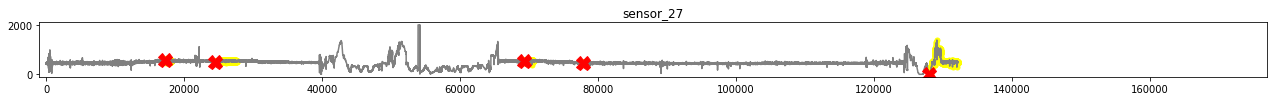

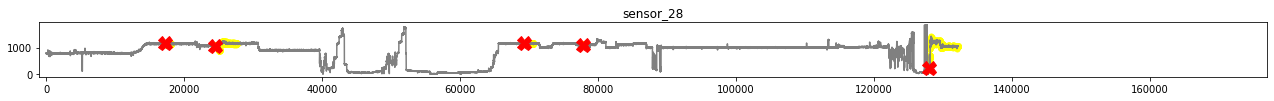

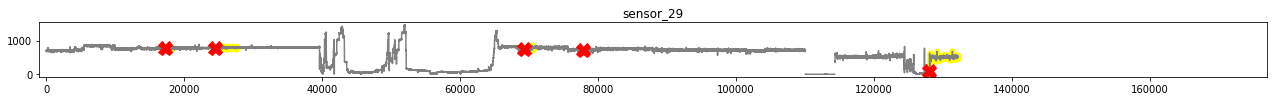

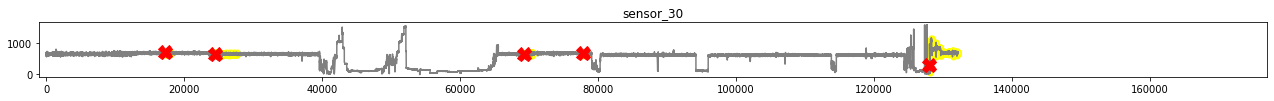

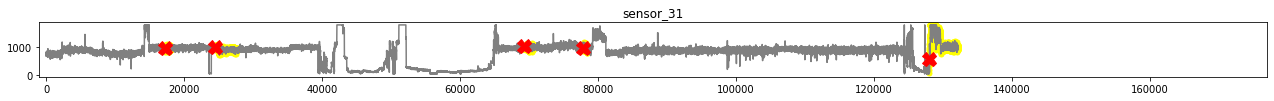

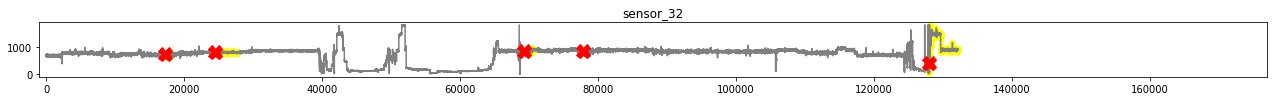

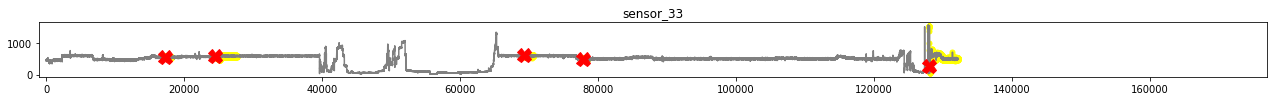

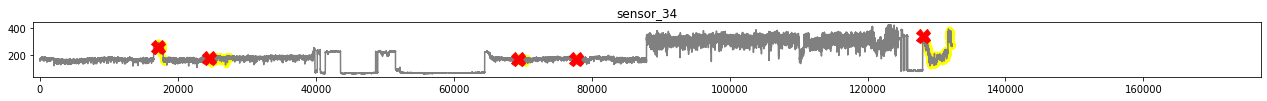

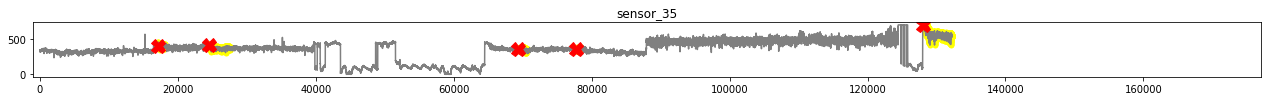

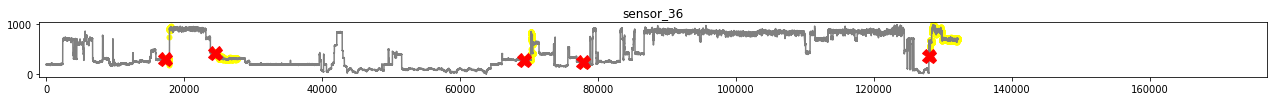

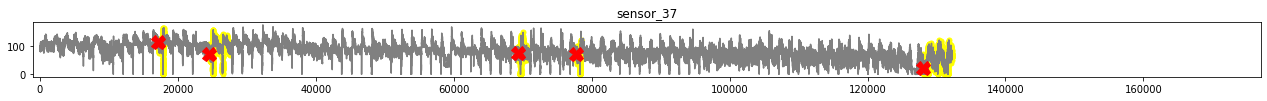

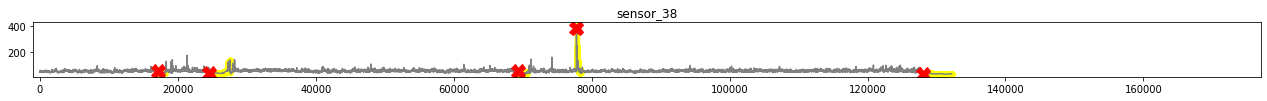

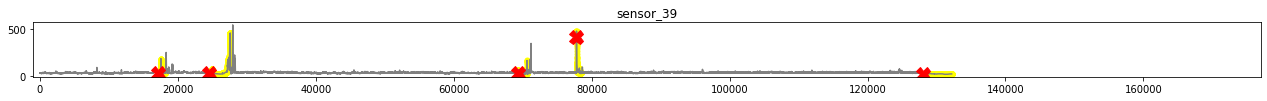

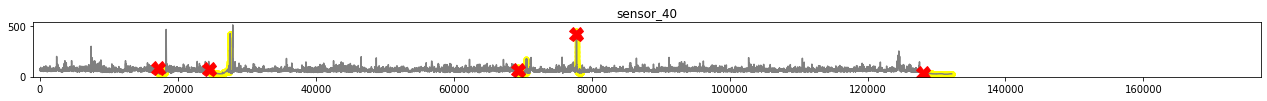

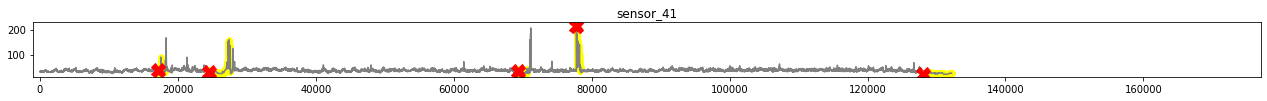

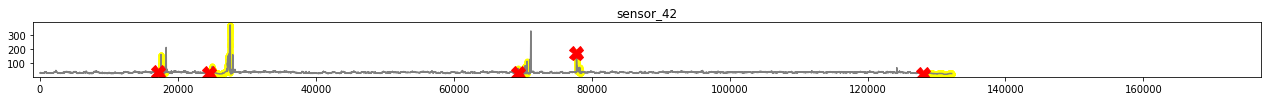

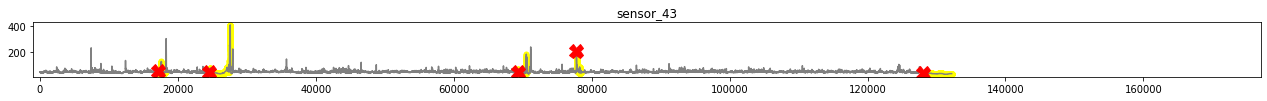

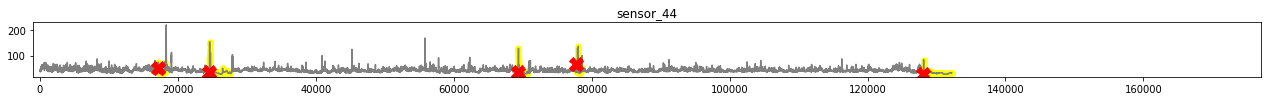

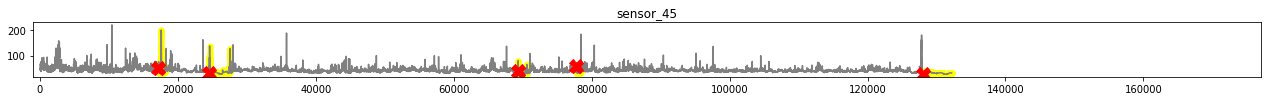

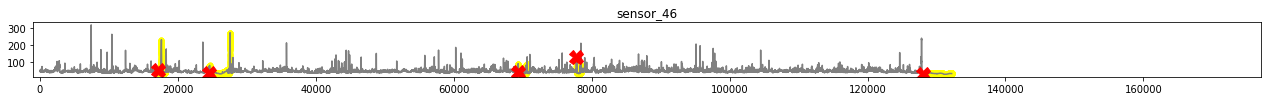

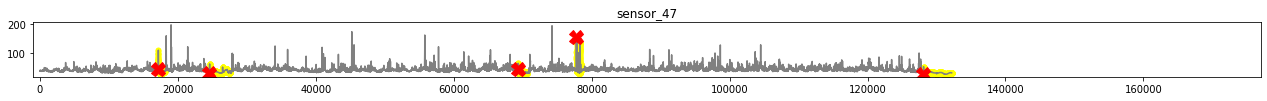

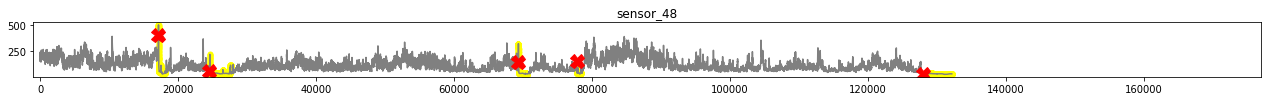

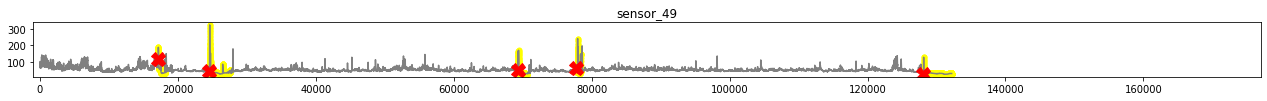

In [15]:
# this cell is hidden for easier notebook readability.

# This visualization loop was inspired from JANANI KARIYAWASAM found at 
# https://www.kaggle.com/code/jananikariyawasam/data-cleaning-and-feature-engineering

for sensor in sensor_cols:
    plot = plt.figure(figsize=(22,1))
    plot = plt.plot(recovery_rows[sensor], linestyle='none', marker='o', color='yellow', markersize=5)
    plot = plt.plot(train[sensor], color='grey')
    plot = plt.plot(broken_rows[sensor], linestyle='none', marker='X', color='red', markersize=14)
    plot = plt.title(sensor)
    plt.xlim((-1000,177000))
    plt.show();

As someone who does not know very much about water pumps and their sensors, we will look at these plots for patterns (as we should anyway). First, we see that many of the plots have large changes around the x-marker 40000-65000 time, as well as around 130000 time. Some sensors drop to very low values, some increase, while others (which are normally consistent) flutter greatly. We see that in these times the machine has failed and is recovering at least once. This could be an indictator for predicting failure. This brings us to the next task: dealing with missing data.

--------
# 2. Preprocessing 🤓

In section 1, we already did a little bit of preprocessing by deleting unnecessary columns. Now we will work with missing data. We have a few options when it comes to missing data. We can impute (fill) it with a constant value (such as 0, 10, etc), the mean of that sensor, or even delete those rows. For this project, it seems that the missing values are associated with when the machine goes down. This makes sense because if the machine is down the sensor might go down as well if they are connected. For this reason we will can use forward or backward propogation. 

After that, we will look into feature extraction and dimensionality reduction using Principle Component Analysis which is an unsupervised learning model techinque.

Steps for preprocessing this dataset:
1. Handle missing data with forward fill
2. Normalize 
3. Dimensionalty reduction with PCA

In [16]:
# split data into X and y (data and labels)         
X_cols = train.iloc[ : , 1:-1].columns
X_train = train.iloc[:,1:-1].copy()
y_train = train['machine_status']

In [17]:
#fill NA's with forward fill propogation
X_train = X_train.fillna(method='ffill')

In [18]:
# normalize data 
normalize = Normalizer()
X_train = normalize.fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_train.columns = X_cols

The curse of dimensionality is a real problem in machine learning. For a very simple example, I tried to run a covariance matrix on the training data but since the data is very large in shape, the notebook ran out of memory and restarts. To solve this, I could have used a larger notebook but instead, let's reduce the dimensionality of the data. Not only will it help with memory but also, dimensionality reduction by means of PCA can help us find the most useful features to use in the model(s) which generally results in better performance. By using Sklearn's PCA, we can actually set the model to find the "number of components such that the amount of variance that needs to be explained is greater than the percentage specified" (2022, scikit-learn developers). Here, we will set the explained variance to 99%. 

In [19]:
#create PCA model
pca = PCA(n_components = .99, svd_solver = 'full', random_state = RANDOMSTATE )
pca.fit(X_train)
print(f'Number of components after reduction: {pca.n_components_}')

Number of components after reduction: 16


In [20]:
# look at explained variances
pca.explained_variance_

array([0.09629125, 0.00890455, 0.00644001, 0.0038204 , 0.00263758,
       0.00227281, 0.00158987, 0.00131147, 0.00112446, 0.00102644,
       0.00093835, 0.00073091, 0.00055499, 0.00045077, 0.00043499,
       0.00026746])

In [21]:
# code hidden for easier readability

# view the most important features which we will use to train the predictive model
# For this code snippet, I got help from Amunnelly at 
# https://discuss.dizzycoding.com/recovering-features-names-of-explained_variance_ratio_-in-pca-with-sklearn/
 
n_comps = pca.n_components_
most_important_comps = [np.abs(pca.components_[i]).argmax() for i in range(n_comps)]
intital_features = list(X_train.columns)
most_important_sensors = [intital_features[most_important_comps[i]] for i in range(n_comps)]
dic = {'PC{}'.format(i+1): most_important_sensors[i] for i in range(n_comps)}
df = pd.DataFrame(sorted(dic.items()))
print("Most Important Features") 
df

Most Important Features


,0,1
0,PC1,sensor_04
1,PC10,sensor_32
2,PC11,sensor_32
3,PC12,sensor_48
4,PC13,sensor_33
5,PC14,sensor_48
6,PC15,sensor_23
7,PC16,sensor_16
8,PC2,sensor_36
9,PC3,sensor_27


In [22]:
# transform the data using the trained PCA model to reduce dimensionality
reduced_X_train = pca.transform(X_train)

Let's visualize the features after all the preprocessing. We see that we have 16 sensors which seem to follow some sort of pattern. Hopefully our model can pick up on these patterns and give us a solid model to work with. 

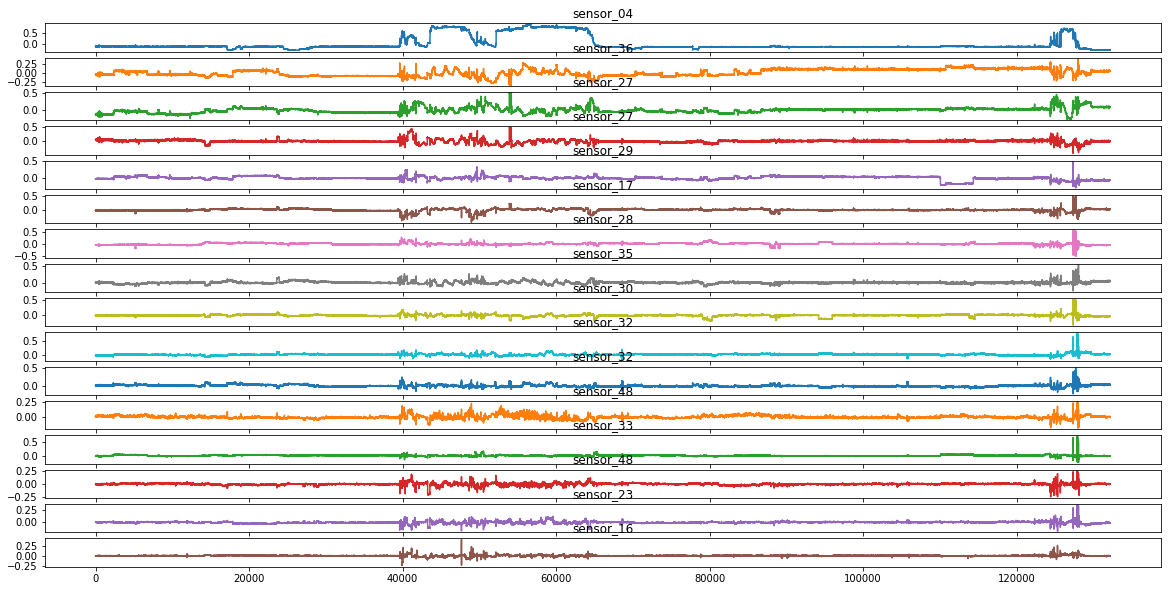

In [23]:
# this cell is hidden for easier readability

# replot the features we will use in the predictive model
pd.DataFrame(reduced_X_train).plot(subplots =True, 
                                   sharex = True, 
                                   figsize = (20,10),
                                   title = most_important_sensors, 
                                   legend = False);

Covariance shows you how the two variables differ, whereas correlation shows you how the two variables are related. Let's look below at the correlation between features which we will use in our model later. We see the red diagonal which is where a feature is correlated to itself (which should be 1 because it's itself). Then we see some lightly negative correlations in later sensors. 

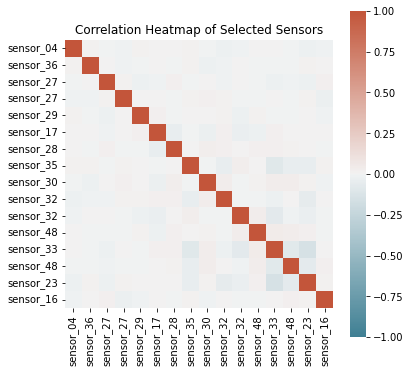

In [24]:
# This cell is hidden for easier readability

plt.figure(figsize = (6,6))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap((pd.DataFrame(reduced_X_train).sample(n=10000, replace=True, random_state=RANDOMSTATE)).corr(), 
            square = True, cmap = cmap, vmin = -1, vmax = 1,
            yticklabels = most_important_sensors, xticklabels = most_important_sensors)
plt.title('Correlation Heatmap of Selected Sensors');

Let's also look at the covariance matrix as well. The off-diagonal has the covariances of each pair of variables while the diagonal covers the the variances of each feature. 

In [25]:
#This cell is hidden for easier readability

# Covariance Matrix
# sample 10,0000 values from the data so that we can create a covarianc matrix (otherwise its too large)
print('Covariance Matrix')
pd.DataFrame(reduced_X_train, columns=most_important_sensors).sample(n=10000, replace=True).cov()

Covariance Matrix


,sensor_04,sensor_36,sensor_27,sensor_27,sensor_29,sensor_17,sensor_28,sensor_35,sensor_30,sensor_32,sensor_32,sensor_48,sensor_33,sensor_48,sensor_23,sensor_16
sensor_04,0.097913,3.453592e-05,0.000003,0.000131,0.000146,-0.000027,0.000036,-0.000016,0.000046,-0.000153,0.000013,0.000091,-0.000003,-0.000161,3.581988e-05,-0.000029
sensor_36,0.000035,8.920767e-03,0.000145,0.000038,-0.000105,0.000054,0.000034,0.000028,-0.000024,-0.000022,0.000041,0.000047,0.000006,-0.000013,-1.341993e-07,0.000014
sensor_27,0.000003,1.451429e-04,0.006269,0.000036,-0.000016,-0.000030,0.000009,-0.000037,-0.000004,-0.000036,-0.000081,-0.000026,0.000037,0.000018,-1.933930e-06,-0.000012
sensor_27,0.000131,3.781016e-05,0.000036,0.003740,-0.000017,-0.000127,0.000027,0.000062,0.000051,-0.000031,-0.000018,-0.000048,-0.000036,-0.000053,-3.623566e-06,-0.000031
sensor_29,0.000146,-1.046144e-04,-0.000016,-0.000017,0.002684,0.000008,-0.000003,0.000054,-0.000021,0.000010,0.000002,0.000004,0.000008,0.000007,2.909560e-05,0.000006
sensor_17,-0.000027,5.373994e-05,-0.000030,-0.000127,0.000008,0.002250,-0.000051,-0.000020,0.000053,-0.000024,-0.000009,0.000029,-0.000058,0.000042,2.267747e-06,0.000029
sensor_28,0.000036,3.427766e-05,0.000009,0.000027,-0.000003,-0.000051,0.001582,-0.000044,-0.000074,0.000023,-0.000016,0.000010,-0.000010,-0.000004,6.290869e-06,-0.000013
sensor_35,-0.000016,2.800347e-05,-0.000037,0.000062,0.000054,-0.000020,-0.000044,0.001361,-0.000009,-0.000018,0.000019,-0.000002,0.000043,0.000013,1.139925e-05,-0.000003
sensor_30,0.000046,-2.426024e-05,-0.000004,0.000051,-0.000021,0.000053,-0.000074,-0.000009,0.001188,0.000004,0.000010,-0.000011,-0.000032,0.000008,8.494321e-06,0.000015
sensor_32,-0.000153,-2.164157e-05,-0.000036,-0.000031,0.000010,-0.000024,0.000023,-0.000018,0.000004,0.001002,0.000038,-0.000023,0.000058,0.000007,1.453167e-05,-0.000003


-----
# 3. Modeling 🦾

For this project we will try an unsupervised learning technique to try to predict failures by training a KMeans Clustering model. We will use Sklearn to build this model. We hope that our model can successfully identify failures, as well as recovering instances. KMeans models build n-clusters based on distances and bundles them together to its closest mean. For this project, I wanted to use SKlearn's GridSearchCV to find the best parameters. However, this would make it difficult since GridSearchCv uses cross-validation. Since this is unsupervised learning we cannot use cross-validation so easily. To be able to get the performance and find the best parameters, I decided to make my own function as follows. 

In [26]:
# function used in class to find the best labels in an unsupervised model

def label_permute_compare(y,ypred, n=3):
    """A helper function to find the best label - number combo """
    results = pd.DataFrame(y)
    perms = list(itertools.permutations([0, 1, 2]))      #create permutation list
    best_labels = []
    best_acc = 0 
    current = {}
    labels = ['NORMAL', 'BROKEN', 'RECOVERING']
    for perm in perms:
        for i in range(n):
            current[labels[i]] = perm[i]
            if len(current) == 3:
                conditions = [
                    (y['machine_status'] == current['NORMAL']),
                    (y['machine_status'] == current['BROKEN']),
                    (y['machine_status'] == current['RECOVERING'])]
                results['test'] = results['machine_status'].map(current)
                current_accuracy = accuracy_score(results['test'], ypred)
                if current_accuracy > best_acc: 
                    best_acc = current_accuracy
                    best_labels = perm
                    results['best'] = results['test']
    return best_labels, best_acc


We want to visualize the errors in a KMeans model to help find how many clusters to use to train the model. We generally look for an elbow shape and based our value on that. However, as we can see below, our plot does not have a defined elbow shape. Therefore, we will use other means to find the best number of clusters for the model. 

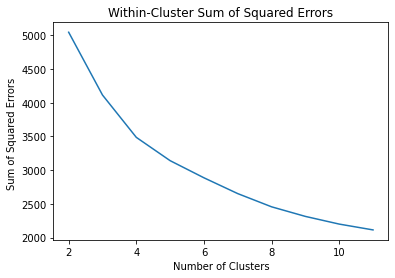

In [27]:
# visualize errors based on number of clusters
error = []
K = range(2,12)
for k in K:
    kmeans = KMeans(n_clusters = k, 
                    max_iter = 500, 
                    init = 'k-means++', 
                    n_init = 20, 
                    random_state = RANDOMSTATE)
    kmeans_fit = kmeans.fit(reduced_X_train)
    error.append(kmeans.inertia_)

plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors ')
plt.title('Within-Cluster Sum of Squared Errors')
plt.plot(K,error);

In [28]:
# find best KMeans model parameters based on the training data
parameters = {'algorithm' : ['auto', 'elkan'], 
              'n_clusters':[3,4,5]}

model_results = {}
ytrue = pd.DataFrame(y_train, columns=['machine_status'])
for alg in parameters['algorithm']: 
    for n in parameters['n_clusters']:
        kmeans = KMeans(n_clusters = n,
                        algorithm = alg,
                        max_iter = 500, 
                        init = 'k-means++', 
                        random_state = RANDOMSTATE)
        kmeans.fit(reduced_X_train)
        ypred = kmeans.predict(reduced_X_train)
        best_labels, best_acc = label_permute_compare(ytrue,ypred, n=3)
        model_results[(alg, n)] = {'accuracy':round(best_acc, 4), 'labels': best_labels}

In [29]:
# show model results based on parameters set in model 
model_results

{('auto', 3): {'accuracy': 0.425, 'labels': (2, 0, 1)},
 ('auto', 4): {'accuracy': 0.3794, 'labels': (2, 0, 1)},
 ('auto', 5): {'accuracy': 0.3748, 'labels': (0, 1, 2)},
 ('elkan', 3): {'accuracy': 0.425, 'labels': (2, 0, 1)},
 ('elkan', 4): {'accuracy': 0.3794, 'labels': (2, 0, 1)},
 ('elkan', 5): {'accuracy': 0.3748, 'labels': (0, 1, 2)}}

The highest accuracy is 0.425 with any parameter values, as long as n_clusters=3. Which is great and as we expected. We will use 3 clusters in our Kmeans model and test it on the testing set. Note, 42.5% accuracy is not high and we would have hoped for better. But let's continue because models aren't always perfect. We will discuss this further in the conclusion. 

In [30]:
# train kmeans model with best parameters
kmeans = KMeans(n_clusters = 3, 
                algorithm = 'auto',
                init = 'k-means++',
                max_iter = 500,
                random_state = RANDOMSTATE)
kmeans.fit(reduced_X_train)

KMeans(max_iter=500, n_clusters=3, random_state=101)

Now we have our KMeans model ready to go. We will test it on our test set. We must first preprocess our test data just like we did the training data so that the model has the best chance of success. The reason we did not apply fillna(), Normalizer() and PCA on the whole dataset (training and test together) is because that can lead to data leakage and impact the final results, and even cause false results. For this, we split first then apply separately. 

In [31]:
# preprocess testing data as we did with the training data
X_cols = test.iloc[ : , 1:-1].columns
X_test = test.iloc[:,1:-1].copy()
y_test = test['machine_status']
X_test = X_test.fillna(method='ffill')
normalize = Normalizer(copy=True)
X_test = normalize.fit_transform(X_test[most_important_sensors])

In [32]:
# predict the testing set using KMeans
ypred = kmeans.predict(X_test)
ytrue = pd.DataFrame(y_test, columns=['machine_status'])
best_labels, best_acc = label_permute_compare(ytrue,ypred, n=3)
print('Test Accuracy:', round(best_acc,4), '\n', 'Best labels:', best_labels)

Test Accuracy: 0.9444 
 Best labels: (2, 0, 1)


In [33]:
# Look at precision and recall 
precision, recall, fscore, support = precision_recall_fscore_support(ytrue['best'], ypred, 
                                                                     zero_division=1, 
                                                                     average = 'micro')
print('Test Precision:', round(precision,4))
print('Test Recall:   ', round(recall, 4))

Test Precision: 0.9444
Test Recall:    0.9444


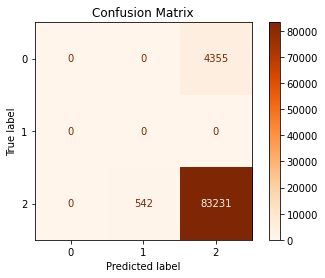

In [34]:
# create visual confusion matrix
ConfusionMatrixDisplay.from_predictions(ytrue['best'], ypred, cmap='Oranges')
plt.title('Confusion Matrix')
plt.show();

In [35]:
print(f'Unique values in test predictions: {list(np.unique(ypred))}')

Unique values in test predictions: [1, 2]


When looking at the performance metrics, we notice that statistically the model is  balanced because accuracy = precision = recall. This suggests that the model is able to correctly classify positive and negative samples at the same rate. However, it is misleading because not only does our model do quite poorly with training performance, we must look at the confusion matrix to get an idea of what is happening for the testing performance. We see mostly zeros. In fact, it really only correctly predicted 1's and 2's which correspond (based on our best labels function) NORMAL and RECOVERING, respectively. What this means is that our model didn't even identify a single BROKEN in the test data (but we know there are two occurances). This is unfortunate because we were hoping for a model which would correctly identify when the pump is broken. However, we do notice that it correctly identified many 2's (which is the NORMAL). We could say that the model did very well identifying normal clusters, or, by understanding the data, we could argue that because almost all of the data was normal and comparatively only a small amount was recovering or broken that the model could have selected 2 (normal) for all occurances and gotten similar results. We will discuss this further in the conclusions section. 

------
# 4. Model Comparison 🤜🤛

We have a workable unsupervised learning model. However, we also want to compare it to other machine learning techniques. Let's compare it a supervised learning model, K-Nearest Neighbors, which is another clustering technique. For these models we will use the preprocessed version of the training and testing data, by applying the same preprocessing and dimensionality reduction technqiues. Then we will apply a clustering technique (K-nearest neighbors, KNN) to find failure (BROKEN) within a given timeframe.

In [36]:
# re-preprocess data to ensure fresh start of training and testing data
X_train = train.iloc[:,1:-1].copy()
y_train = train['machine_status']
X_train = X_train.fillna(method='ffill')
normalize = Normalizer()
X_train = normalize.fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_train.columns = X_cols
pca = PCA(n_components = .99, svd_solver = 'full', random_state = RANDOMSTATE )
pca.fit(X_train)
reduced_X_train = pca.transform(X_train)

most_important_sensors = [intital_features[most_important_comps[i]] for i in range(n_comps)]

X_test = test.iloc[:,1:-1].copy()
y_test = test['machine_status']
X_test = X_test.fillna(method='ffill')
normalize = Normalizer(copy=True)
X_test = normalize.fit_transform(X_test[most_important_sensors])

We have preprocessed our data again to ensure a clean slate in the new model. Now we'll use GridSearchCV with KNN to find the best parameters to use with this model.

In [37]:
# find best KNN using gridsearch
parameters = {'n_neighbors': [3, 5, 10], 
             'weights': ['uniform', 'distance'], 
             'algorithm': ['ball_tree', 'kd_tree'], 
             'p': [1, 2]}
grid_KNN = GridSearchCV(estimator = KNeighborsClassifier(), 
                        param_grid = parameters, 
                        cv = 3) 
grid_KNN.fit(reduced_X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree'],
                         'n_neighbors': [3, 5, 10], 'p': [1, 2],
                         'weights': ['uniform', 'distance']})

In [38]:
# what are the best parameters we found?
best_param = grid_KNN.best_params_
print("Best parameters:", best_param)

Best parameters: {'algorithm': 'ball_tree', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}


In [39]:
# KNN train best model
KNN = KNeighborsClassifier(n_neighbors = best_param['n_neighbors'],
                          algorithm = best_param['algorithm'],
                          p = best_param['p'], 
                          weights = best_param['weights'])
KNN.fit(reduced_X_train, y_train)

KNeighborsClassifier(algorithm='ball_tree', p=1)

In [40]:
# test the testing set with KNN
ypred = KNN.predict(X_test)

We now have a workable KNN model and its predictions. Let's visualize it! We will use just one sensor (sensor_04) to visualize the outcome since all the normal, recovering and broken occurances are at the same point in time for all sensors. 

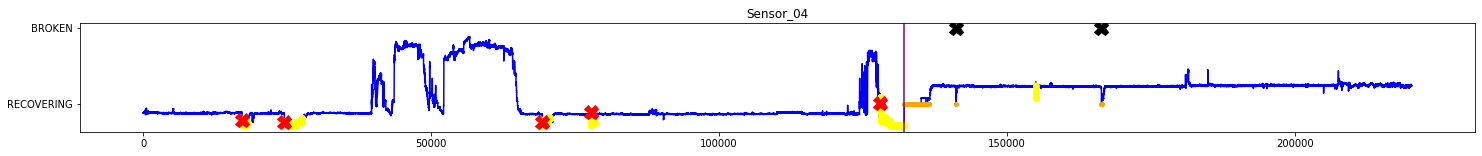

In [41]:
#Cell hidden for easier readability

# Visualize the clusters. 
# First combine the test and training into one
KNN_data = pd.DataFrame(np.concatenate((reduced_X_train, X_test)))
KNN_data.columns =  most_important_sensors
KNN_data['cluster'] = np.concatenate((y_train, ypred))
KNN_data['time'] = pd.to_datetime(sensor_data['timestamp'])
unique_elements, counts_elements = np.unique(ypred, return_counts=True)
clusters = np.asarray((unique_elements, counts_elements))
KNN_data['cluster_num'] = KNN_data['cluster'].map({'BROKEN': 0, 'NORMAL':1, 'RECOVERING':2})

colors = ['red', 'limegreen', 'yellow']
colors_plot = [colors[i] for i in KNN_data['cluster_num'].values]
sensors_to_plot = ['sensor_04']  #sensor 04 explains the most variance from the PCA model

#continue coloring 
broken_rows = KNN_data[KNN_data['cluster']=='BROKEN']
recovery_rows = KNN_data[KNN_data['cluster']=='RECOVERING']
normal_rows = KNN_data[KNN_data['cluster']=='NORMAL']
true_broken_rows = y_test[y_test=='BROKEN'] 
true_recovery_rows = y_test[y_test=='RECOVERING']

#create plot
plt.figure(figsize=(25,2))
plot = plt.plot(KNN_data['sensor_04'], color='blue', label='sensor data')
plot = plt.plot(recovery_rows['sensor_04'], linestyle='none', marker='o', color='yellow', markersize=5)
plot = plt.plot(broken_rows['sensor_04'], linestyle='none', marker='X', color='red', markersize=14)

plot = plt.plot(true_recovery_rows, linestyle='none', marker='o', color='orange', markersize=3)
plot = plt.plot(true_broken_rows, linestyle='none', marker='X', color='black', markersize=14)
plot = plt.axvline(x=132060, color='purple')

plot = plt.title('Sensor_04')
plt.show()

Let's examine this plot above. See the purple verticle line? That is where the training set ends and the test set begins. Yellow is where the model guessed the recovering status, red is broken and blue is normal. We see on the lefthand side (the training side) that the model did well which is expected because in a supervised learning model the model is given the training data with labels so of course it knows where the correct labels go. However, when we look to the right of the vertical line at the testing set, we see a different story. First, the model guessed recovering (yellow) where it should not have (orange is the true recovering values). Next, we see that model didn't predict any broken ocurrances (which should be red x's) however, we know where they should have been (black x). Note, the X is placed above the line for easier readability and reference with recovering values. Visually, it does not look like the model did well with the testing set but let's look at the performance metrics too.

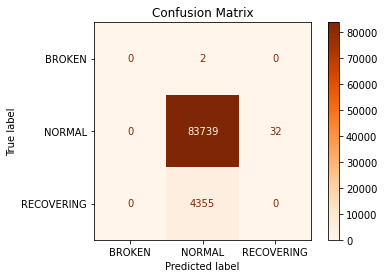

KNN Test Results
Test Accuracy: 0.9502
Test Precision: 0.9502
Test Recall: 0.9502


In [42]:
# show test statistics and results
conf_matrix = ConfusionMatrixDisplay.from_predictions(y_test, ypred, cmap='Oranges')
plt.title('Confusion Matrix')
plt.show();
acc = accuracy_score(y_test, ypred)
precision, recall, fscore, support = precision_recall_fscore_support(y_test, ypred, 
                                                                     zero_division=1, 
                                                                     average = 'micro')
print('KNN Test Results')
print('Test Accuracy:', round(acc, 4))
print('Test Precision:', round(precision, 4))
print('Test Recall:', round(recall, 4))

We can see with our supervised learning model that it actually did very similiarly to our unsupervised model (but we will discuss this more in the next session). We can see that, like the Kmeans model, our KNN model only guessed NORMAL and RECOVERING. Both models seemed to have struggled identifying BROKEN into clusters. We see that again accuracy = precision = recall which could mean that the model is a well-balanced model in normal circumstances however, as expressed for KMeans we see that the model is mostly guessing normal and probably would have gotten similar results if it only guessed NORMAL because the data is so unbalanced. 

------
# 5. Conclusion and Future Suggestions 👏

Let's review what we did in this project. First we explored the data given to us and visualized it. It is suggested not to view all the data before splitting into testing and training sets but for learning experience and this project specifically, we decided to look at it all first. Then we visualized the data to get a better since of the patterns. Next, we did data preprocessing by dealing with missing data with forward-fill propogation. We used PCA to find the most useful features (columns) to use when trainging the models. We then trained many KMeans and KNN models and found the best one for each. Finally, we compared the models performance. Overall we used three models: two unsupervised models including PCA and KMeans Clusters and one supervised model using KNN. 

We saw in both the KMeans and the KNN models that the test accuracy, precision, and recall seemed quite good. However, by understanding our data and investigating further, we know that is probably not the case. Our data was very unbalanced; almost all the data was labeled NORMAL, then we had some RECOVERING, and very few BROKEN instances. What this means for our models is that it had a hard time identifying anything other than NORMAL. This is important in real-life situations to be aware of. By just looking at the performance test results, we might have thought we got a fantastic model. But the truth is that we were not able to find a single BROKEN instance either the KNN nor the KMeans models.

Every project should recommend ways to enhance their work. For this project, we would recommend using more data with more variety. As said, this data was very unbalanced. Ways to do this would be to find more data, create more data, or even artificially create more data. Another recommendation would be to use different models other than KNN and KMeans. Models which are more geared towards anomaly detection (such as a forest or SVM) or predictive maintanence algorthims (such as a regression model to find remaining useful life by using similiarity measures) could have done a better job than our presented models. Lastly, having more water pumps to compare to this pump may have helped the algorithms learn better. 

_______
# References and Useful Links

Geller, S. (2019, April 5). Normalization vs standardization - quantitative analysis. Medium. Retrieved July 19, 2022, from https://towardsdatascience.com/normalization-vs-standardization-quantitative-analysis-a91e8a79cebf 

Griffin, S. (2021, April 11). Machine learning for equipment failure prediction and predictive maintenance (PM). Medium. Retrieved July 19, 2022, from https://medium.com/swlh/machine-learning-for-equipment-failure-prediction-and-predictive-maintenance-pm-e72b1ce42da1 

Jananikariyawasam. (2021, October 14). Data Cleaning and feature engineering. Kaggle. Retrieved July 19, 2022, from https://www.kaggle.com/code/jananikariyawasam/data-cleaning-and-feature-engineering 

MATLAB. (2019, July 2). Predictive maintenance: Unsupervised and supervised machine learning. YouTube. Retrieved July 19, 2022, from https://www.youtube.com/watch?v=AS0H43hMoWM&amp;t=1430s 

Polanitzer, R. (2022, June 14). Remaining useful life prediction for an engine based on sensors; building a gradient boosting in... Medium. Retrieved July 19, 2022, from https://medium.com/@polanitzer/remaining-useful-life-prediction-for-an-engine-based-on-sensors-building-a-gradient-boosting-in-d9181a2eb8cf 

Zhao, K. (2019, December 10). Feature extraction using principal component analysis - A simplified visual demo. Medium. Retrieved July 19, 2022, from https://towardsdatascience.com/feature-extraction-using-principal-component-analysis-a-simplified-visual-demo-e5592ced100a 

*This project was completed for course DTSA-5510 Unsupervised Algorithms in Machine Learning under the Masters in Data Science degree program at the University of Colorado Boulder. We thank the data owners for their contribution to Kaggle!*

END